Experiment for consistency result for the (do intervention) CFI consistency, larger number of repetition will be done in a script on server.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KernelCenterer
from sklearn.kernel_ridge import KernelRidge

from kernelbiome.kernels_jax import *
from kernelbiome.metrics_jax import *
from kernelbiome.utils_cv import *
from kernelbiome.utils_result import *
from kernelbiome.cfi_and_cpd import *

/Users/hrt620/.pyenv/versions/3.9.9/envs/kb39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
from matplotlib import rc
rc('font', **{'family':'tex-gyre-termes', 'size':6.5})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsfonts,amssymb,amsthm,amsmath}')

### Local tries

Data generation functions

In [64]:
rng = np.random.default_rng(2022)

In [88]:
# Note: this ref_pt is a global variable
p = 9
ref_pt = np.array([0.06544714, 0.08760064, 0.17203408, 0.07502236, 0.1642615,
                   0.03761901, 0.18255478, 0.13099514, 0.08446536])

def true_fun_(x):
    return 100*k_hilbert2(x, ref_pt, a=1, b=-np.inf)

def true_fun(X):
    return vmap(true_fun_)(X)

In [89]:
def gen_data(n):
    mu = [0, 0, 0]
    cov = [[1, 0.25, -0.25],
           [0.25, 1, 0.25],
           [-0.25, 0.25, 1]]
    X1 = rng.multivariate_normal(mu, cov, n)  # 0, 1, 2
    X2 = rng.multivariate_normal(mu, cov, n)  # 3, 4, 5
    X3 = rng.multivariate_normal(mu, cov, n)  # 6, 7, 8
    X = np.concatenate([X1, X2, X3], axis=1)
    X = np.exp(X)
    X /= X.sum(axis=1)[:, None]
    y = true_fun(X) + rng.normal(0, 1, n)
    return X, y

Calculate true CFI

In [90]:
n = 10**3
p = 9
n_grid = 50
supp_grid = get_gen_grid(n_grid, p, 0.01, 0.99)
X, y = gen_data(n)
cpd_vals_true = get_cpd(X, supp_grid, true_fun)

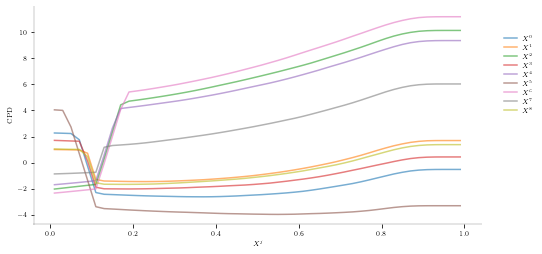

In [91]:
fig, axs = plt.subplots(1,1,figsize=(8,4))
plot_cpd(supp_grid, cpd_vals_true, labels=[f'$X^{jj}$' for jj in range(X.shape[1])], axs=axs)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1, 0.8), frameon=False)
plt.show()

#### Consistency of CPD under correct and incorrect model specifications

In [92]:
def run_consistency(ns, gen_data_fun, estimator_fun, n_repeat=10):
    """
    ns: List
        a list of number of samples.
    gen_data_fun: Callable
        a function that takes only the number of samples n and returns X, y
    estimator: Callable
        a function that takes X, y and returns a prediction function, the selected hyperparameters, kernel matrix function, and the name of the kernel
    """
    cpd_est_list = []
    for ii, n in enumerate(ns):
        # clear_output(wait=True)
        print(f'-- ii = {ii} (n = {n}) --')
        cpd_loc = np.zeros((n_repeat, p, n_grid))
        for jj in range(n_repeat):
            X, y = gen_data_fun(n)
            pred_fun, gscv, kmat_fun, kernel_args_str = estimator_fun(X, y)
            cpd_loc[jj] = get_cpd(X, supp_grid, pred_fun)
        cpd_est_list.append(cpd_loc)
    # average MSE of the 9 curves at each sample size n
    mse = np.zeros((len(ns), n_repeat))
    for ii, n in enumerate(ns):
        for jj in range(n_repeat):
            # MSE of each curve, shape is (p,)
            mse_loc = np.mean((cpd_vals_true-cpd_est_list[ii][jj])**2, axis=1)
            mse[ii, jj] = np.mean(mse_loc)
    return pd.DataFrame(mse.T, columns=ns)

Hyperparameter grid for GridSearchCV

In [93]:
param_grid_kr = dict(alpha=[1/10**x for x in [-1, 0, 1, 2, 3]])
print(param_grid_kr)

{'alpha': [10.0, 1.0, 0.1, 0.01, 0.001]}


Correctly specified model

In [123]:
ns = [100, 200, 500]
n_repeat = 5
def my_estimator(X, y):
    model = KernelRidge(kernel="precomputed")
    gscv = GridSearchCV(estimator=model, param_grid=param_grid_kr, scoring='neg_mean_squared_error', n_jobs=8, verbose=0)
    K = kmat_hilbert2(X,X,a=1,b=-np.inf)
    transformer = KernelCenterer().fit(K)
    K = transformer.transform(K)
    intercept = np.mean(y)
    gscv.fit(K, y-intercept)
    print(gscv.best_estimator_)
    def pred_fun(X_new):
        K_new = kmat_hilbert2(X_new,X,a=1,b=-np.inf)
        K_new = transformer.transform(K_new)
        return gscv.best_estimator_.predict(K_new) + intercept
    return pred_fun, gscv, wrap(kmat_hilbert2, a=1, b=-np.inf), 'kmat_hilbert2_a_1_b_neginf'
mse_df = run_consistency(ns, gen_data, my_estimator, n_repeat)

-- ii = 0 (n = 100) --
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.01, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
-- ii = 1 (n = 200) --
KernelRidge(alpha=0.1, kernel='precomputed')
KernelRidge(alpha=0.01, kernel='precomputed')
KernelRidge(alpha=0.01, kernel='precomputed')
KernelRidge(alpha=0.01, kernel='precomputed')
KernelRidge(alpha=0.01, kernel='precomputed')
-- ii = 2 (n = 500) --
KernelRidge(alpha=0.1, kernel='precomputed')
KernelRidge(alpha=0.1, kernel='precomputed')
KernelRidge(alpha=0.1, kernel='precomputed')
KernelRidge(alpha=0.1, kernel='precomputed')
KernelRidge(alpha=0.1, kernel='precomputed')


In [124]:
mse_df

,100,200,500
0,1.318920,0.511889,0.165636
1,0.914409,1.040478,0.244620
2,0.704951,0.501469,0.237562
3,0.729419,0.474697,0.097934
4,0.559579,0.827588,0.345911


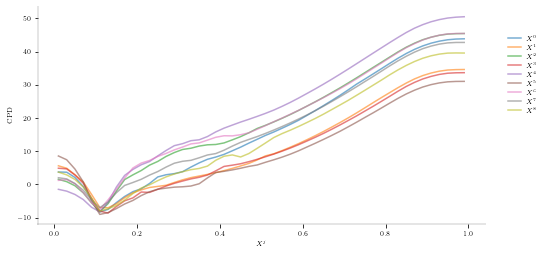

In [115]:
fig, axs = plt.subplots(1,1,figsize=(8,4))
plot_cpd(supp_grid, cpd_loc, labels=[f'$X^{jj}$' for jj in range(X.shape[1])], axs=axs)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1, 0.8), frameon=False)
plt.show()

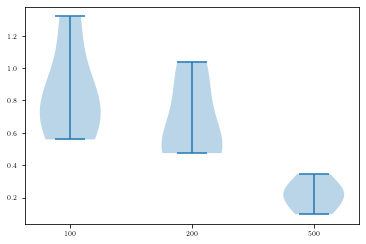

In [125]:
fig, axs = plt.subplots()
axs.violinplot(mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

Misspecified model 1

In [127]:
ns = [100, 200, 500]
n_repeat = 5
def my_estimator(X,y):
    model = KernelRidge(kernel="precomputed")
    gscv = GridSearchCV(estimator=model, param_grid=param_grid_kr, scoring='neg_mean_squared_error', n_jobs=8, verbose=0)
    K = kmat_rbf(X,X,g=0.01)
    transformer = KernelCenterer().fit(K)
    K = transformer.transform(K)
    intercept = np.mean(y)
    gscv.fit(K, y-intercept)
    print(gscv.best_estimator_)
    def pred_fun(X_new):
        K_new =  kmat_rbf(X_new,X,g=0.01)
        K_new = transformer.transform(K_new)
        return gscv.best_estimator_.predict(K_new) + intercept
    return pred_fun, gscv, wrap(kmat_rbf, g=0.01), 'kmat_rbf_g_0.01'
mse_df = run_consistency(ns, gen_data, my_estimator, n_repeat)

-- ii = 0 (n = 100) --
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
-- ii = 1 (n = 200) --
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
-- ii = 2 (n = 500) --
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')


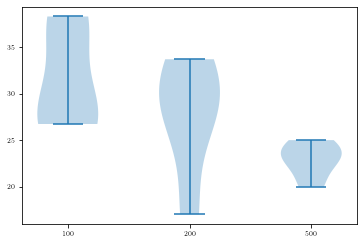

In [128]:
fig, axs = plt.subplots()
axs.violinplot(mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

Misspecified model 2

In [132]:
ns = [100, 200, 500]
n_repeat = 5
def my_estimator(X,y):
    model = KernelRidge(kernel="precomputed")
    gscv = GridSearchCV(estimator=model, param_grid=param_grid_kr, scoring='neg_mean_squared_error', n_jobs=8, verbose=0)
    K = kmat_chisq(X,X)
    transformer = KernelCenterer().fit(K)
    K = transformer.transform(K)
    intercept = np.mean(y)
    gscv.fit(K, y-intercept)
    print(gscv.best_estimator_)
    def pred_fun(X_new):
        K =  kmat_chisq(X_new,X)
        K = transformer.transform(K)
        return gscv.best_estimator_.predict(K) + intercept
    return pred_fun, gscv, kmat_chisq, 'kmat_chisq'
mse_df = run_consistency(ns, gen_data, my_estimator, n_repeat)

-- ii = 0 (n = 100) --
KernelRidge(alpha=0.01, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.01, kernel='precomputed')
KernelRidge(alpha=0.01, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
-- ii = 1 (n = 200) --
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
-- ii = 2 (n = 500) --
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')
KernelRidge(alpha=0.001, kernel='precomputed')


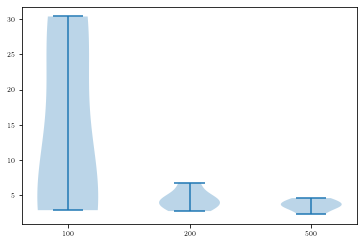

In [133]:
fig, axs = plt.subplots()
axs.violinplot(mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

### Results collected from server

Process output gathered from sever (dgp6 with kr -- final result)

In [96]:
cfi_mse_df = pd.read_csv("output/kr_pert_cfi_idx_mse_df_seed_0.csv")
for ii in range(1,100):
    try:
        tmp = pd.read_csv(f"output/output_dgp6_kr_v4/kr_pert_cfi_idx_mse_df_seed_{ii}.csv")
        cfi_mse_df = pd.concat([cfi_mse_df, tmp])
    except:
        print(f"seed {ii} not found.")
        pass
cfi_mse_df.shape

(100, 4)

In [97]:
cfi_mse_df

,50,100,200,500
0,0.197379,0.104654,0.110904,0.010671
0,0.284599,0.026242,0.095023,0.005636
0,0.115153,0.072444,0.055898,0.007525
0,0.294640,0.048766,0.022071,0.008660
0,0.241276,0.129327,0.082493,0.009816
...,...,...,...,...
0,0.153912,0.191686,0.056058,0.009053
0,0.052766,0.135970,0.065693,0.010492
0,0.175239,0.081433,0.022032,0.120303
0,0.144841,0.083013,0.055058,0.007908


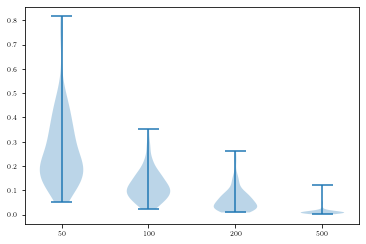

In [98]:
ns = [50, 100, 200, 500]
fig, axs = plt.subplots()
axs.violinplot(cfi_mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

In [101]:
cpd_mse_df = pd.read_csv("output/output_dgp6_kr_v4/kr_cpd_mse_df_seed_0.csv")
for ii in range(1, 100):
    try:
        tmp = pd.read_csv(f"output/output_dgp6_kr_v4/kr_cpd_mse_df_seed_{ii}.csv")
        cpd_mse_df = pd.concat([cpd_mse_df, tmp])
    except:
        print(f"seed {ii} not found.")
        pass
cpd_mse_df.shape

(100, 4)

In [102]:
cpd_mse_df

,50,100,200,500
0,3.465466,1.504303,0.399457,0.239741
0,2.093588,2.143393,0.810565,0.300492
0,2.608136,0.894293,0.350104,0.312943
0,0.653279,0.916638,0.994999,0.505922
0,1.758674,0.646007,1.358335,0.774867
...,...,...,...,...
0,1.504000,1.340078,0.152901,0.331695
0,1.136028,1.248937,0.336075,0.408765
0,2.402035,1.297449,0.476145,0.238445
0,5.527133,2.158115,0.596671,0.321968


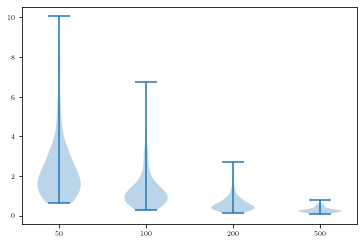

In [103]:
ns = [50, 100, 200, 500]
fig, axs = plt.subplots()
axs.violinplot(cpd_mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

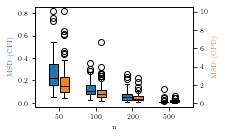

In [104]:
fig, ax1 = plt.subplots()
res1 = ax1.boxplot(
    cfi_mse_df, widths=0.25, positions = np.arange(1, len(ns)+1)-0.15,
    patch_artist=True,
)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(res1[element], color='k')

for patch in res1['boxes']:
    patch.set_facecolor('tab:blue')
ax1.set_xlabel('n')
ax1.set_ylabel('MSD (CFI)', color='tab:blue')

ax2 = ax1.twinx()
res2 = ax2.boxplot(
    cpd_mse_df, widths=0.25, positions = np.arange(1, len(ns)+1)+0.15,
    patch_artist=True,
)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(res2[element], color='k')

for patch in res2['boxes']:
    patch.set_facecolor('tab:orange')
ax2.set_ylabel('MSD (CPD)', color='tab:orange')

ax1.set_xticks(range(1, len(ns)+1))
ax1.set_xticklabels(ns)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# plt.style.use("seaborn-white")
fig.set_size_inches(2.6, 1.6)
fig.savefig("../../writeup/consistency_cfi_and_cpd.pdf", bbox_inches='tight')
plt.show()